<a href="https://colab.research.google.com/github/ashishkumarsaklani/AIML/blob/main/OLA_Ensemble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [407]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
from sklearn.linear_model import LinearRegression,SGDRegressor,ElasticNet,LogisticRegression
from sklearn.model_selection import train_test_split ,KFold, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score,accuracy_score,precision_score,recall_score, confusion_matrix,f1_score,roc_auc_score
from sklearn.preprocessing import StandardScaler,MinMaxScaler,PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer


import re

In [367]:
url = "https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/002/492/original/ola_driver_scaler.csv"
df = pd.read_csv(url)

Features like MMMM-YY (reporting date) might be helpful in seasonal trends. Considering feature engineering (e.g., extracting month or year) if relevant.


Driver_ID likely won't contribute to prediction but can be kept for identification purposes.

Age and Income could be important, assuming they influence driver behavior and performance.

Gender might have an effect

City could be relevant depending on location-specific factors affecting business value.

Education_Level importance might be moderate.

Date Of Joining may be less relevant or if we calculate tenure

LastWorkingDate can be used feature engineering and to make our target (dependent variable) Y  considering active drivers.

Joining Designation might be important if it's indicative of skill or experience level. Consider feature engineering (e.g., encoding designation categories).

Grade likely reflects driver performance and is likely relevant
.
Total Business Value (target variable).

Quarterly Rating could be highly relevant as it directly assesses driver performance.

In [368]:

df =df.drop('Unnamed: 0',axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19104 entries, 0 to 19103
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   MMM-YY                19104 non-null  object 
 1   Driver_ID             19104 non-null  int64  
 2   Age                   19043 non-null  float64
 3   Gender                19052 non-null  float64
 4   City                  19104 non-null  object 
 5   Education_Level       19104 non-null  int64  
 6   Income                19104 non-null  int64  
 7   Dateofjoining         19104 non-null  object 
 8   LastWorkingDate       1616 non-null   object 
 9   Joining Designation   19104 non-null  int64  
 10  Grade                 19104 non-null  int64  
 11  Total Business Value  19104 non-null  int64  
 12  Quarterly Rating      19104 non-null  int64  
dtypes: float64(2), int64(7), object(4)
memory usage: 1.9+ MB


Unnamed column seems irrelevant

In [369]:
df.head()

,MMM-YY,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating
0,01/01/19,1,28.0,0.0,C23,2,57387,24/12/18,NaN,1,1,2381060,2
1,02/01/19,1,28.0,0.0,C23,2,57387,24/12/18,NaN,1,1,-665480,2
2,03/01/19,1,28.0,0.0,C23,2,57387,24/12/18,03/11/19,1,1,0,2
3,11/01/20,2,31.0,0.0,C7,2,67016,11/06/20,NaN,2,2,0,1
4,12/01/20,2,31.0,0.0,C7,2,67016,11/06/20,NaN,2,2,0,1


One interesting observation in a data is that we do not have a direct dependent variable or output variable so many need to create feature en active users or churned users

#Feature engineering adding a new column Active User

In [370]:
df['Active_User'] = np.where((df['Dateofjoining'].notna()) & (df['LastWorkingDate'].isna()), 1, 0)
df['Active_User'] = np.where(df['LastWorkingDate'].notna(), 0, df['Active_User'])

Converting city to int so classifier can handle it

In [371]:
df['City'] = df['City'].str.extract('(\d+)', expand=False).astype(int)

In [372]:
df.head()

,MMM-YY,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating,Active_User
0,01/01/19,1,28.0,0.0,23,2,57387,24/12/18,NaN,1,1,2381060,2,1
1,02/01/19,1,28.0,0.0,23,2,57387,24/12/18,NaN,1,1,-665480,2,1
2,03/01/19,1,28.0,0.0,23,2,57387,24/12/18,03/11/19,1,1,0,2,0
3,11/01/20,2,31.0,0.0,7,2,67016,11/06/20,NaN,2,2,0,1,1
4,12/01/20,2,31.0,0.0,7,2,67016,11/06/20,NaN,2,2,0,1,1


In [373]:
class IQROutlierDetector:

  def __init__(self, data, column_name):

    self.data = data
    self.column_name = column_name

  def detect_outliers(self):


    if not pd.api.types.is_numeric_dtype(self.data[self.column_name]):
      #print(f"Warning: Column '{self.column_name}' is not numerical. Skipping outlier detection.")
      return None  # Indicate non-numerical column

    q1 = self.data[self.column_name].quantile(0.25)
    q3 = self.data[self.column_name].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers = self.data[(self.data[self.column_name] < lower_bound) | (self.data[self.column_name] > upper_bound)].index.tolist()
    return outliers

  def get_outlier_count(self):

    outliers = self.detect_outliers()
    if outliers is None:
        return 0  # Handle case of non-numerical column
    else:
        return len(outliers)

  def get_outlier_percentage(self):

    outlier_count = self.get_outlier_count()
    total_data_points = len(self.data)
    if total_data_points > 0:
        return (outlier_count / total_data_points) * 100
    else:
        return 0  # Handle case of empty data

  def drop_outliers(self):

    outliers = self.detect_outliers()
    if outliers is None:
        return self.data  # Return original data if column is not numerical
    else:
        return self.data.drop(outliers)

#checking outliers

In [374]:
for col in df.columns:
  detector = IQROutlierDetector(df, col)
  outlier_indices = detector.detect_outliers()
  #print("Outlier indices:", outlier_indices)

  outlier_count = detector.get_outlier_count()
  outlier_percentage = detector.get_outlier_percentage()
  if detector.get_outlier_count() > 0 :
    print(f"{col} Number of outliers:", outlier_count)
    print(f"{col} Percentage of outliers:", outlier_percentage, "%")
    #df = detector.drop_outliers()

Age Number of outliers: 78
Age Percentage of outliers: 0.4082914572864322 %
Income Number of outliers: 188
Income Percentage of outliers: 0.9840871021775545 %
Joining Designation Number of outliers: 471
Joining Designation Percentage of outliers: 2.4654522613065324 %
Total Business Value Number of outliers: 1371
Total Business Value Percentage of outliers: 7.176507537688442 %
Active_User Number of outliers: 1616
Active_User Percentage of outliers: 8.458961474036851 %


#Null Values

In [375]:
print((df.isnull().sum()[df.isnull().sum() > 0]).sort_values())

Gender                52
Age                   61
LastWorkingDate    17488
dtype: int64


#Duplicates

In [376]:
duplicate = df.duplicated()
duplicate.sum()

0

In [377]:
df['Driver_ID'].duplicated().sum()

16723

This indicate we have multiple entries for us every  driver and data PS to be in a long format data

#Unique Values

In [378]:
print((df.nunique()).sort_values()[-5:])

LastWorkingDate           493
Dateofjoining             869
Driver_ID                2381
Income                   2383
Total Business Value    10181
dtype: int64


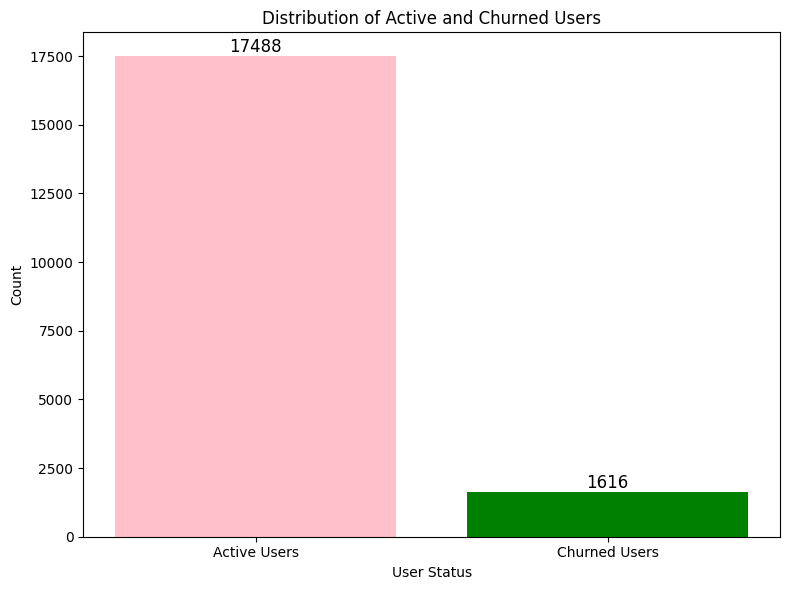

In [379]:

# Count active and churned users
active_count = df[df['Active_User'] == 1].shape[0]
churned_count = df[df['Active_User'] == 0].shape[0]

# Create a list of user categories (active, churned)
user_categories = ['Active Users', 'Churned Users']

# Create a list of colors (pink, green)
colors = ['pink', 'green']

# Create the bar plot
plt.figure(figsize=(8, 6))  # Adjust figure size as desired
plt.bar(user_categories, [active_count, churned_count], color=colors)

# Add labels and title
plt.xlabel('User Status')
plt.ylabel('Count')
plt.title('Distribution of Active and Churned Users')

# Add data labels on top of each bar
for i, v in enumerate([active_count, churned_count]):
    plt.text(i, v + 0.1, str(v), ha='center', va='bottom', fontsize=12)

# Display the plot
plt.xticks(rotation=0)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

Doesn't look right because we have duplicate values for driver ID so when it to find unique ID

In [380]:
active_count = df[df['Active_User'] == 1].shape[0]
active_count

17488

In [381]:
inactive_count = df[df['Active_User'] == 0].shape[0]
inactive_count

1616

In [382]:
df['LastWorkingDate'] = df['LastWorkingDate'].astype('datetime64')
df['Dateofjoining'] = df['Dateofjoining'].astype('datetime64')
df['MMM-YY'] = df['MMM-YY'].astype('datetime64')

In [383]:
# Group data by Driver_id
g_df = df.groupby('Driver_ID')

# Create a new empty DataFrame to store unique driver attributes
data = pd.DataFrame(columns=['Driver_ID','Education_Level', 'Gender', 'City', 'Dateofjoining', 'LastWorkingDate'])

In [384]:

# Define a function to extract unique attributes and populate a row
def get_driver_attributes(group):
  # Assuming these columns exist in your original DataFrame
  driver_id = group['Driver_ID'].iloc[0]
  education_level = group['Education_Level'].iloc[0]  # Access first value for unique attributes
  gender = group['Gender'].iloc[0]
  city = group['City'].iloc[0]
  date_of_joining = group['Dateofjoining'].min()  # Use min for earliest joining date
  last_working_date = group['LastWorkingDate'].max()  # Access first value
  if pd.notna(last_working_date):  # Check if not null (missing)
    try:
      # Assuming 'LastWorkingDate' format (modify if different)
      last_working_date = pd.to_datetime(last_working_date).date()
    except ValueError:
      # Handle potential parsing errors (e.g., invalid format)
      last_working_date = None  # Or assign a specific value for errors

  return pd.Series({'Driver_ID': driver_id,
                   'Education_Level': education_level,
                   'Gender': gender,
                   'City': city,
                   'Dateofjoining': date_of_joining,
                   'LastWorkingDate': last_working_date})

In [385]:
# Apply the function to each group and append results to the new DataFrame
data = data.append(g_df.apply(get_driver_attributes), ignore_index=True)

# Now you have a DataFrame 'data' with unique attributes for each driver

data.head()

<ipython-input-385-5d718adf84c7>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(g_df.apply(get_driver_attributes), ignore_index=True)


,Driver_ID,Education_Level,Gender,City,Dateofjoining,LastWorkingDate
0,1,2,0.0,23,2018-12-24,2019-03-11
1,2,2,0.0,7,2020-11-06,NaT
2,4,2,0.0,13,2019-12-07,2020-04-27
3,5,0,0.0,9,2019-01-09,2019-03-07
4,6,1,1.0,11,2020-07-31,NaT


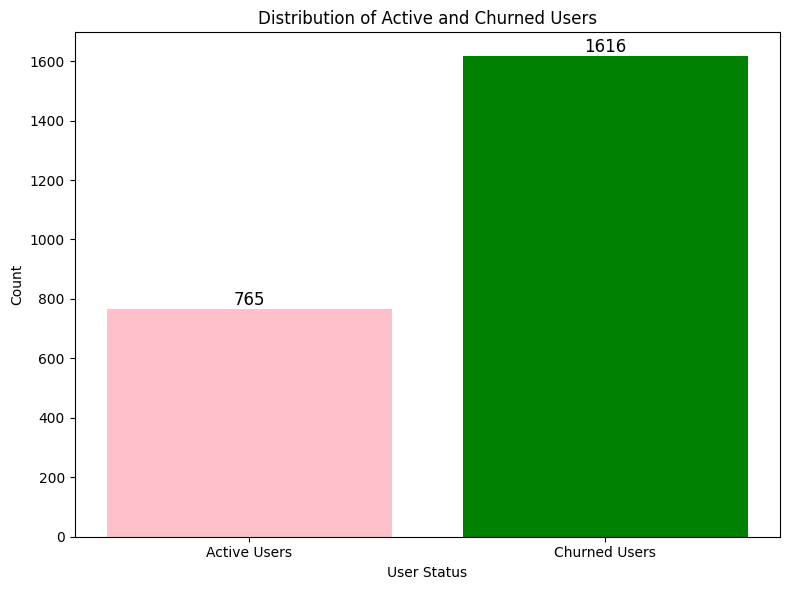

In [386]:

data['Active_User'] = np.where((data['Dateofjoining'].notna()) & (data['LastWorkingDate'].isna()), 1, 0)
data['Active_User'] = np.where(data['LastWorkingDate'].notna(), 0, data['Active_User'])

# Count active and churned users
active_count = data[data['Active_User'] == 1].shape[0]
churned_count = data[data['Active_User'] == 0].shape[0]

# Create a list of user categories (active, churned)
user_categories = ['Active Users', 'Churned Users']

# Create a list of colors (pink, green)
colors = ['pink', 'green']

# Create the bar plot
plt.figure(figsize=(8, 6))  # Adjust figure size as desired
plt.bar(user_categories, [active_count, churned_count], color=colors)

# Add labels and title
plt.xlabel('User Status')
plt.ylabel('Count')
plt.title('Distribution of Active and Churned Users')

# Add data labels on top of each bar
for i, v in enumerate([active_count, churned_count]):
    plt.text(i, v + 0.1, str(v), ha='center', va='bottom', fontsize=12)

# Display the plot
plt.xticks(rotation=0)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

Looking at the data currently total data points 17k we only have 2.5k unique drivers so maybe I am thinking let's create a new data frame data frame and completely new set of extracted features may be that improve the performance of a model and then we can compare if the feature engineering then make any significant impact  on the models performance

In [387]:
df.sort_values('Driver_ID').head(5)

,MMM-YY,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating,Active_User
0,2019-01-01,1,28.0,0.0,23,2,57387,2018-12-24,NaT,1,1,2381060,2,1
1,2019-02-01,1,28.0,0.0,23,2,57387,2018-12-24,NaT,1,1,-665480,2,1
2,2019-03-01,1,28.0,0.0,23,2,57387,2018-12-24,2019-03-11,1,1,0,2,0
3,2020-11-01,2,31.0,0.0,7,2,67016,2020-11-06,NaT,2,2,0,1,1
4,2020-12-01,2,31.0,0.0,7,2,67016,2020-11-06,NaT,2,2,0,1,1


Before that checking some different entries in data and many to handle they time format because random forest only works with integer or float values

In [388]:
def handle_datetime(df):
  """
  Converts datetime columns in a DataFrame to a float representation (YYYY.MM format).

  Args:
    df: A pandas DataFrame.

  Returns:
    A pandas DataFrame with datetime columns converted to float.
  """
  for col in df.columns:
    if pd.api.types.is_datetime64_dtype(df[col]):
      try:
        # Attempt conversion using strftime for '%Y.%m' format
        pattern = r"(\d{4})-(\d{2})"  # Regular expression to capture year and month (YYYY-MM)
        df[col] = df[col].dt.strftime('%Y.%m').astype(float)
      except (re.error, ValueError):
        pass  # Handle potential errors (e.g., invalid datetime format, conversion error)
  df = df.fillna(0)
  return df

In [389]:
#checking unique values in first column
#df['MMM-YY'] = df['MMM-YY'].dt.strftime('%Y-%m')
df['MMM-YY'].unique()
#df['MMM-YY'].dtype

array(['2019-01-01T00:00:00.000000000', '2019-02-01T00:00:00.000000000',
       '2019-03-01T00:00:00.000000000', '2020-11-01T00:00:00.000000000',
       '2020-12-01T00:00:00.000000000', '2019-12-01T00:00:00.000000000',
       '2020-01-01T00:00:00.000000000', '2020-02-01T00:00:00.000000000',
       '2020-03-01T00:00:00.000000000', '2020-04-01T00:00:00.000000000',
       '2020-08-01T00:00:00.000000000', '2020-09-01T00:00:00.000000000',
       '2020-10-01T00:00:00.000000000', '2019-07-01T00:00:00.000000000',
       '2019-08-01T00:00:00.000000000', '2019-09-01T00:00:00.000000000',
       '2019-10-01T00:00:00.000000000', '2019-11-01T00:00:00.000000000',
       '2019-04-01T00:00:00.000000000', '2019-05-01T00:00:00.000000000',
       '2019-06-01T00:00:00.000000000', '2020-05-01T00:00:00.000000000',
       '2020-06-01T00:00:00.000000000', '2020-07-01T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [390]:

# Identify rows where values in 'col1' are the same but values in 'col2' are different
#mask = df.duplicated(subset='col1', keep=False) & ~df.duplicated(subset='col2', keep=False)
mask = df.iloc[:,1].astype(str).duplicated(keep=False) #& ~df.duplicated(subset= df.iloc[:,2].astype(str), keep=False)

mask2 = ~df.iloc[:,6].astype(str).duplicated(keep=False)



# Apply the mask to filter rows
df[mask & mask2].sort_values('Driver_ID').nunique()

MMM-YY                   2
Driver_ID               11
Age                      9
Gender                   2
City                     9
Education_Level          3
Income                  11
Dateofjoining           11
LastWorkingDate          2
Joining Designation      2
Grade                    4
Total Business Value    11
Quarterly Rating         4
Active_User              2
dtype: int64

In [391]:

mask3 = df.duplicated(subset='Driver_ID', keep=False) & ~df.duplicated(subset='Income', keep=False)

df[mask3].sort_values('Driver_ID')

,MMM-YY,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating,Active_User
1951,2020-10-01,307,39.0,0.0,26,0,88207,2018-10-05,2020-10-26,2,4,500050,1,0
3974,2020-12-01,580,42.0,1.0,18,2,56877,2018-07-27,NaT,1,2,755970,4,1
7027,2020-12-01,1050,32.0,1.0,28,1,35462,2018-01-07,NaT,1,2,766310,3,1
8135,2020-12-01,1206,42.0,1.0,15,1,72584,2019-06-28,NaT,2,3,989340,3,1
8474,2020-12-01,1249,23.0,0.0,5,1,37143,2020-01-14,NaT,1,2,434890,2,1
11922,2020-12-01,1770,38.0,1.0,4,2,92440,2016-05-02,NaT,1,4,150370,1,1
12200,2020-12-01,1817,41.0,1.0,8,1,64154,2015-07-26,NaT,1,3,572780,2,1
12324,2020-12-01,1840,31.0,1.0,6,1,38183,2017-11-21,NaT,1,3,1442530,4,1
12681,2020-10-01,1877,40.0,1.0,26,0,126742,2019-04-29,2020-09-28,1,5,0,1,0
12936,2020-12-01,1918,31.0,1.0,21,0,73070,2017-08-14,NaT,1,3,2191670,4,1


#Convertd data to wideformat for DT classifier with tools at disposal hoping it can also highlight some factors with a given timeframe of data which were not specifically mentioned in data but may have affected churn

In [392]:
data['LastWorkingDate'].nunique()

493

In [393]:

data['LastWorkingDate'] = data['LastWorkingDate'].astype('datetime64')
data['Dateofjoining'] = data['Dateofjoining'].astype('datetime64')


data['TenureDays'] = np.where(pd.isna(data['LastWorkingDate']),
                          pd.to_datetime('2020-12-31 00:00:00') - data['Dateofjoining'],
                          data['LastWorkingDate'] - data['Dateofjoining'])

# Handle potential type errors (optional)
#if not pd.api.types.is_datetime64_dtype(data['Tenure']):
#  data['Tenure'] = pd.to_timedelta(data['Tenure'])

# Now you have a DataFrame 'data' with a 'Tenure' column

<ipython-input-393-7d23f51a070f>:2: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  data['Dateofjoining'] = data['Dateofjoining'].astype('datetime64')


In [394]:
data['TenureDays'] = data['TenureDays'].dt.days

In [395]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2381 entries, 0 to 2380
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Driver_ID        2381 non-null   object        
 1   Education_Level  2381 non-null   object        
 2   Gender           2375 non-null   float64       
 3   City             2381 non-null   object        
 4   Dateofjoining    2381 non-null   datetime64[ns]
 5   LastWorkingDate  1616 non-null   datetime64[ns]
 6   Active_User      2381 non-null   int64         
 7   TenureDays       2381 non-null   int64         
dtypes: datetime64[ns](2), float64(1), int64(2), object(3)
memory usage: 148.9+ KB


In [396]:
# X = data.drop(columns=['Active_User','City','Dateofjoining','LastWorkingDate'],axis = 1)
# y = data['Active_User']

# y.value_counts()
# X.shape,y.shape
# from imblearn.over_sampling  import SMOTE
# smt = SMOTE()
# print(type(X))
# X.info()
# X_s , y_s = smt.fit_resample(X,y)

In [397]:
pivot_df = df

In [398]:

# Handle potential missing values in 'LastWorkingDate'
pivot_df['LastWorkingDate'].fillna(pd.NA, inplace=True)

# Convert 'Dateofjoining' to datetime64 if necessary (assuming UTC timezone)
if not pd.api.types.is_datetime64_dtype(pivot_df['Dateofjoining']):
    pivot_df['Dateofjoining'] = pd.to_datetime(pivot_df['Dateofjoining'])

# Calculate 'TenureDays' (assuming both dates are in the same year)
pivot_df['TenureDays'] = (pivot_df['LastWorkingDate'] - pivot_df['Dateofjoining']).dt.days.fillna(0)  # Handle missing 'LastWorkingDate' with 0 days

# Create a boolean column indicating active users based on 'LastWorkingDate'
pivot_df['Active_User'] = pivot_df['LastWorkingDate'].notnull().astype(int)

# Convert to wide format using pivot_table
wide_df = pivot_df.pivot_table(index='Driver_ID',
                         values=['Education_Level', 'Gender', 'City', 'Total Business Value', 'Quarterly Rating', 'TenureDays', 'Active_User'],
                         aggfunc={'TenureDays': 'sum', 'Active_User': 'sum',  # Aggregate 'TenureDays' and 'Active_User'
                                  'Education_Level': 'first',  # Choosing aggregation for other columns
                                  'Gender': 'first',
                                  'City': 'first',
                                  'Total Business Value': 'sum',
                                  'Quarterly Rating': 'sum'})  # Choosing aggregation for other columns

# Reset the index to make 'Driver_ID' a regular column
wide_df = wide_df.reset_index()

wide_df

,Driver_ID,Active_User,City,Education_Level,Gender,Quarterly Rating,TenureDays,Total Business Value
0,1,1,23,2,0.0,6,77.0,1715580
1,2,0,7,2,0.0,2,0.0,0
2,4,1,13,2,0.0,5,142.0,350000
3,5,1,9,0,0.0,3,57.0,120360
4,6,0,11,1,1.0,8,0.0,1265000
...,...,...,...,...,...,...,...,...
2376,2784,0,24,0,0.0,63,0.0,21748820
2377,2785,1,9,0,1.0,3,61.0,0
2378,2786,1,19,0,0.0,15,418.0,2815090
2379,2787,1,20,2,1.0,9,334.0,977830


#train test validation split

In [399]:
class DataPreparer:
    def __init__(self, test_size=0.2, random_state=42):
        self.test_size = test_size
        self.random_state = random_state

    def prepare_data(self, data, target_variable):
        X = data.drop(target_variable, axis=1)
        y = data[target_variable]

        X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=self.test_size, random_state=self.random_state)

        # Further split training-validation set (assuming 80% train, 20% validation)
        X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=self.random_state)

        return X_train, X_val, X_test, y_train, y_val, y_test

In [400]:
# moving this up so we can get same thing on all df
# wide_df['City'] = wide_df['City'].str.extract('(\d+)', expand=False).astype(int)

In [401]:

#splitdata = DataPreparer(test_size=0.3, random_state=47)  # Explicitly specify arguments
#X_train, X_val, X_test, y_train, y_val, y_test = splitdata.prepare_data(wide_df,'Active_User')

#random forest model

In [423]:



class ChurnPredictor:
  def __init__(self, n_estimators=100, random_state=42):
    self.pipeline = Pipeline([
        ('classifier', RandomForestClassifier(n_estimators=n_estimators, random_state=random_state))
    ])



  def fit_predict(self, data, target_variable, test_size=0.2):
    data = handle_datetime(data)
    splitdata = DataPreparer(test_size=0.3, random_state=47)  # Explicitly specify arguments
    X_train, X_val, X_test, y_train, y_val, y_test = splitdata.prepare_data(data,'Active_User')
    print(X_train.columns)

    self.pipeline.fit(X_train, y_train)

    y_pred_v = self.pipeline.predict(X_val)
    y_pred_t = self.pipeline.predict(X_test)

    # Evaluation metrics
    accuracy_v = accuracy_score(y_val, y_pred_v)
    accuracy_t = accuracy_score(y_test, y_pred_t)
    precision_v = precision_score(y_val, y_pred_v)
    precision_t = precision_score(y_test, y_pred_t)
    recall_v = recall_score(y_val, y_pred_v)
    recall_t = recall_score(y_test, y_pred_t)
    f1_v = f1_score(y_val, y_pred_v)
    f1_t = f1_score(y_test, y_pred_t)
    auc_roc_v = roc_auc_score(y_val, y_pred_v)
    auc_roc_t = roc_auc_score(y_test, y_pred_t)

    print("Training Accuracy:", accuracy_score(self.pipeline.fit(X_train, y_train).predict(X_train), y_train))  # Add training accuracy
    print("Validation Accuracy:", accuracy_v)
    print("Test Accuracy:", accuracy_t)
    print("Validation Precision:", precision_v)
    print("Test Precision:", precision_t)
    print("Validation Recall:", recall_v)
    print("Test Recall:", recall_t)
    print("Validation F1 Score:", f1_v)
    print("Test F1 Score:", f1_t)
    print("Validation AUC-ROC:", auc_roc_v)
    print("Test AUC-ROC:", auc_roc_t)

    return y_pred_t

In [403]:
wide_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2381 entries, 0 to 2380
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Driver_ID             2381 non-null   int64  
 1   Active_User           2381 non-null   int64  
 2   City                  2381 non-null   int64  
 3   Education_Level       2381 non-null   int64  
 4   Gender                2381 non-null   float64
 5   Quarterly Rating      2381 non-null   int64  
 6   TenureDays            2381 non-null   float64
 7   Total Business Value  2381 non-null   int64  
dtypes: float64(2), int64(6)
memory usage: 148.9 KB


#trying to check performance of model with different dataframes

In [433]:
predictor = ChurnPredictor()
y_pred = predictor.fit_predict(df,'Active_User')  # Using DataFrame df

Training Accuracy: 1.0
Validation Accuracy: 1.0
Test Accuracy: 1.0
Validation Precision: 1.0
Test Precision: 1.0
Validation Recall: 1.0
Test Recall: 1.0
Validation F1 Score: 1.0
Test F1 Score: 1.0
Validation AUC-ROC: 1.0
Test AUC-ROC: 1.0


In [434]:
y_pred =predictor.fit_predict(data,'Active_User')  # Using DataFrame data

Training Accuracy: 1.0
Validation Accuracy: 1.0
Test Accuracy: 1.0
Validation Precision: 1.0
Test Precision: 1.0
Validation Recall: 1.0
Test Recall: 1.0
Validation F1 Score: 1.0
Test F1 Score: 1.0
Validation AUC-ROC: 1.0
Test AUC-ROC: 1.0


There appears to be some some issue with the model or data because we are using random forest and over 100 different decision trees so we can as you meets not over fitting because test and validation scores are also good but we can safely say that is some issue free considered the points again some feature is directly related with our dependent variable so let's check the VIF and removing some feature
#to verify this doubt I prepared a new data frame named data that doesn't have a feature last working day which I thought may be somehow directly interpreted by the model as output variable so I remove that column in this data frame and still accuracy is 100%

In [435]:
y_pred = predictor.fit_predict(wide_df,'Active_User')  # Using DataFrame wide_df

Training Accuracy: 0.9978991596638656
Validation Accuracy: 0.9957983193277311
Test Accuracy: 1.0
Validation Precision: 1.0
Test Precision: 1.0
Validation Recall: 0.9935897435897436
Test Recall: 1.0
Validation F1 Score: 0.9967845659163987
Test F1 Score: 1.0
Validation AUC-ROC: 0.9967948717948718
Test AUC-ROC: 1.0


#initially planned for bagging boosting and hyperparam tuning  but it's getting computationally expensive by looking at these models performance clearly seems it doesn't need those things when cost is high and we don't have much to gain took 11 mins to test one thing

In [421]:

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Define hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [4, 8, 16],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 5, 10],
    'max_features': ["sqrt", "log2", None]  # None considers all features
}

# Create a Random Forest classifier
rf_model = RandomForestClassifier()

# Use GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(rf_model, param_grid, cv=5, scoring="accuracy")
grid_search.fit(X_train, y_train)

# Get the best model and parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Use the best model for prediction
y_pred = best_model.predict(X_test)

In [422]:
best_params

{'max_depth': 4,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 100}

In [432]:

class ChurnPredictor:
    def __init__(self, n_estimators=100, random_state=42,
                 max_depth=4, max_features="sqrt", min_samples_leaf=1, min_samples_split=2):
        """
        Initializes a ChurnPredictor with a Random Forest model and default hyperparameters.

        Args:
            n_estimators (int, optional): The number of trees in the forest (default 100).
            random_state (int, optional): Random seed for reproducibility (default 42).
            max_depth (int, optional): The maximum depth of each tree (default 4).
            max_features (str or int, optional): The number of features to consider at each split
                (default "sqrt" for square root of features).
            min_samples_leaf (int, optional): The minimum number of samples required to be at a leaf node (default 1).
            min_samples_split (int, optional): The minimum number of samples required to split an internal node (default 2).
        """

        self.pipeline = Pipeline([
            ('classifier', RandomForestClassifier(n_estimators=n_estimators,
                                                  random_state=random_state,
                                                  max_depth=max_depth,
                                                  max_features=max_features,
                                                  min_samples_leaf=min_samples_leaf,
                                                  min_samples_split=min_samples_split))
        ])

    def fit_predict(self, data, target_variable, test_size=0.2):
        """
        Prepares data, trains the Random Forest model, and performs predictions.

        Args:
            data: A pandas DataFrame containing the features.
            target_variable: The name of the target variable (column) in the DataFrame.
            test_size: Proportion of data for the testing set (default 0.2).

        Returns:
            A numpy array of predicted labels for the test set.
        """

        data = handle_datetime(data)  # Assuming handle_datetime handles datetime features
        splitdata = DataPreparer(test_size=test_size, random_state=47)  # Explicitly specify arguments
        X_train, X_val, X_test, y_train, y_val, y_test = splitdata.prepare_data(data, 'Active_User')

        self.pipeline.fit(X_train, y_train)

        y_pred_v = self.pipeline.predict(X_val)
        y_pred_t = self.pipeline.predict(X_test)

        # Evaluation metrics
        accuracy_v = accuracy_score(y_val, y_pred_v)
        accuracy_t = accuracy_score(y_test, y_pred_t)
        precision_v = precision_score(y_val, y_pred_v)
        precision_t = precision_score(y_test, y_pred_t)
        recall_v = recall_score(y_val, y_pred_v)
        recall_t = recall_score(y_test, y_pred_t)
        f1_v = f1_score(y_val, y_pred_v)
        f1_t = f1_score(y_test, y_pred_t)
        auc_roc_v = roc_auc_score(y_val, y_pred_v)
        auc_roc_t = roc_auc_score(y_test, y_pred_t)

        print("Training Accuracy:", accuracy_score(self.pipeline.fit(X_train, y_train).predict(X_train), y_train))  # Add training accuracy
        print("Validation Accuracy:", accuracy_v)
        print("Test Accuracy:", accuracy_t)
        print("Validation Precision:", precision_v)
        print("Test Precision:", precision_t)
        print("Validation Recall:", recall_v)
        print("Test Recall:", recall_t)
        print("Validation F1 Score:", f1_v)
        print("Test F1 Score:", f1_t)
        print("Validation AUC-ROC:", auc_roc_v)
        print("Test AUC-ROC:", auc_roc_t)

        return y_pred_t